In [1]:
%matplotlib inline
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds
import datetime
import matplotlib
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

In [2]:
class MACD(bt.Strategy):
    params = (
        ('macd1', 12),
        ('macd2', 26),
        ('sigp', 9)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close

        self.order = None
        self.buyprice = None
        self.buycomm = None

        self.macd = btind.MACD(
            self.data, period_me1=self.p.macd1, period_me2=self.p.macd2, period_signal = self.p.sigp)
        self.crossovr = btind.CrossOver(self.macd.macd, self.macd.signal)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        if self.order:
            return
        if not self.position:
            if self.crossovr > 0:
                self.log('BUY CREATE, %.2f' % self.data.close[0])
                self.order = self.buy()
            elif self.crossovr < 0:
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                self.order = self.sell()
        else:
            if self.getposition(data=self.data).size > 0 and self.crossovr < 0:
                self.log('Long ended, %.2f' % self.data.close[0])
                self.order = self.close()
            elif self.getposition(data=self.data).size<0 and self.crossovr > 0:
                self.log('Short ended, %.2f' % self.data.close[0])  
                self.order = self.close()

In [3]:
cerebro = bt.Cerebro()
data = btfeeds.YahooFinanceCSVData(
        dataname = 'orcl-1995-2014.txt',
        fromdate=datetime.datetime(2004, 1, 1),
        todate=datetime.datetime(2008, 12, 31),
        reverse=False
    )

In [4]:
cerebro.adddata(data)
cerebro.addstrategy(MACD)
cerebro.broker.setcash(100000.0)  
cerebro.broker.setcommission(commission=0.01)
start_portfolio_value = cerebro.broker.getvalue()

In [5]:
cerebro.run()
end_portfolio_value = cerebro.broker.getvalue()
print("Starting portfolio value: %s \nEnding portfolio value: %s \nProfit: %s" \
          %(start_portfolio_value,end_portfolio_value,end_portfolio_value-start_portfolio_value))

2004-02-27, SELL CREATE, 11.45
2004-03-01, SELL EXECUTED, Price: 11.66, Cost: -11.66, Comm 0.12
2004-03-25, Short ended, 10.62
2004-03-26, BUY EXECUTED, Price: 10.61, Cost: -11.66, Comm 0.11
2004-03-26, OPERATION PROFIT, GROSS 1.05, NET 0.83
2004-04-28, SELL CREATE, 10.58
2004-04-29, SELL EXECUTED, Price: 10.56, Cost: -10.56, Comm 0.11
2004-05-13, Short ended, 10.50
2004-05-14, BUY EXECUTED, Price: 10.44, Cost: -10.56, Comm 0.10
2004-05-14, OPERATION PROFIT, GROSS 0.12, NET -0.09
2004-05-19, SELL CREATE, 10.04
2004-05-20, SELL EXECUTED, Price: 10.12, Cost: -10.12, Comm 0.10
2004-05-25, Short ended, 10.23
2004-05-26, BUY EXECUTED, Price: 10.18, Cost: -10.12, Comm 0.10
2004-05-26, OPERATION PROFIT, GROSS -0.06, NET -0.26
2004-06-03, SELL CREATE, 9.76
2004-06-04, SELL EXECUTED, Price: 9.86, Cost: -9.86, Comm 0.10
2004-06-07, Short ended, 10.16
2004-06-08, BUY EXECUTED, Price: 10.16, Cost: -9.86, Comm 0.10
2004-06-08, OPERATION PROFIT, GROSS -0.30, NET -0.50
2004-06-21, SELL CREATE, 9.92
2

<IPython.core.display.Javascript object>


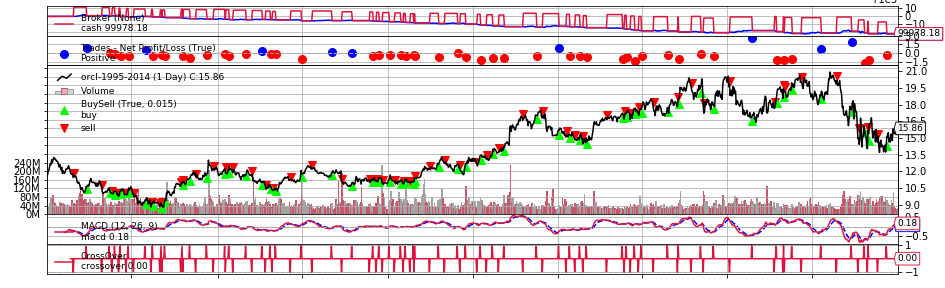

[[<Figure size 432x288 with 6 Axes>]]

In [6]:
cerebro.plot()